In [1]:
import random

import matplotlib.pyplot as plt
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-11-15 19:56:06.010262: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 19:56:06.018710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 19:56:06.028120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 19:56:06.031112: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 19:56:06.038389: I tensorflow/core/platform/cpu_feature_guar

# Transformation de toutes les images en JPEG

In [ ]:
import pathlib
import sys

sys.path.append("..")

from utilitaires.image_util import transform_image_type_to_jpg

data_dir_path = '/home/shared/Mammiferes'

data_dir = pathlib.Path(data_dir_path).with_suffix('')

image_paths = list(data_dir.glob('*/*.*'))

transform_image_type_to_jpg(image_paths)

image_count = len(image_paths)

print(image_count)


# Data Augmentation

Found 252 files belonging to 13 classes.
Using 202 files for training.
Found 252 files belonging to 13 classes.
Using 50 files for validation.
<_ParallelInterleaveDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
3584


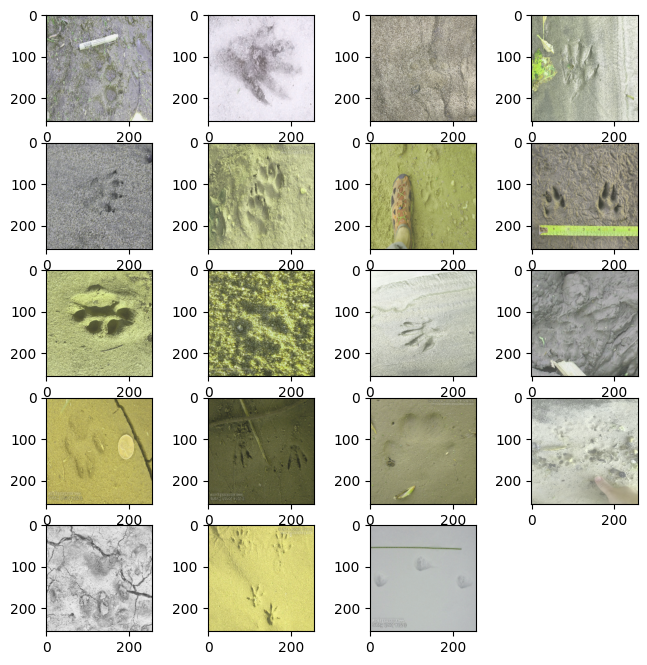

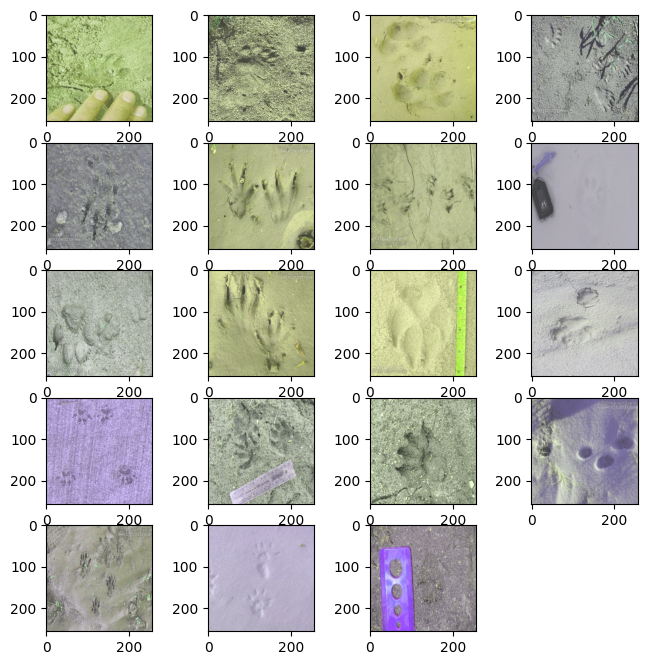

In [5]:

from keras.src.utils import image_dataset_from_directory
from tensorflow.data import Dataset
from random import randint

batch_size = 32

train_ds = image_dataset_from_directory(
    "/home/shared/Mammiferes",
    batch_size=batch_size,
    image_size=(256, 256),
    validation_split=0.2,
    subset="training",
    seed=47
)
val_ds = image_dataset_from_directory(
    "/home/shared/Mammiferes",
    batch_size=batch_size,
    image_size=(256, 256),
    validation_split=0.2,
    subset="validation",
    seed=47
)

image_width, image_height = (256, 256)

rng = tf.random.Generator.from_seed(123, alg='philox')


def resize_and_rescale(x, y):
    x = tf.image.resize(x, [image_width, image_height])
    x = (x / 255.0)
    x = tf.cast(x, tf.float32)
    return x, y

def rotate_tensor(x, y):
    tf.image.rot90(
        x,
        randint(1, 3)
    )
    return x, y


def augment_and_make_seed(x, y):
    seed = rng.make_seeds(1)[:, 0]
    image, label = augment((x, y), seed)
    return image, label


def augment(x_y, seed):
    x, y = x_y
    x, y = resize_and_rescale(x, y)
    # Make a new seed.
    new_seed = tf.random.split(seed, num=1)[0, :]
    # Random brightness.
    x = tf.image.stateless_random_brightness(
        x, max_delta=0.2, seed=new_seed)

    x = tf.image.stateless_random_flip_left_right(
        x, seed=new_seed
    )

    x = tf.image.stateless_random_flip_up_down(
        x, seed=new_seed
    )

    x, y = rotate_tensor(x, y)

    x = tf.image.stateless_random_hue(
        x, max_delta=0.2, seed=new_seed
    )

    x = tf.image.stateless_random_contrast(
        x,
        lower=0,
        upper=1,
        seed=new_seed
    )
    # normalize the data between 0 and 1
    x = tf.clip_by_value(x, 0, 1)

    return x, y


def apply_augmentation(dataset: Dataset) -> Dataset:
    datasets = []
    for _ in range(16):
        datasets.append(dataset.map(augment_and_make_seed))

    final_ds = tf.data.Dataset.from_tensor_slices(datasets)

    concat_ds = final_ds.interleave(
        lambda x: x,
        cycle_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    return concat_ds


augmented_train_dataset = train_ds.apply(apply_augmentation)
print(augmented_train_dataset)

length_dataset = augmented_train_dataset.reduce(0, lambda x, _: x + 1).numpy()
print(length_dataset * batch_size)

for batch in augmented_train_dataset.take(2):
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows):
        fig.add_subplot(rows, columns, i)
        plt.imshow(batch[0][i])

    plt.show()


